In [3]:
from minio import Minio
import s3fs
import os
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import numpy as np
from sympl import get_constant
import metpy
from metpy.units import units

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "http://192.168.1.237:9000"
    },
    key="d0d250b2541ac33f4660",
    secret="2fb32d964768bc94a3c0"
)
output_dir='/home/scratch/Abel_data/hw_processed/ctrl/'


Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

In [ ]:
dp=2000
Lx=np.radians(2.8125)*6371*1000
Ly=np.radians(2.79)*6371*1000

climfile=output_dir+'climatology.nc'
clim=xr.open_dataset(climfile)
p1=clim['air_pressure']
p2=p1.copy()
p2[1:,:]=p1[:-1,:].values[:]
# print(p2, clim['surface_air_pressure'])
p2[0,:]=clim['surface_air_pressure'].values[:]

lat_rad=np.radians(clim['air_temperature'].lat)
z=(Rd*clim['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
dse_clim=Cp*clim['air_temperature']+g*z
u_clim=clim['eastward_wind']; v_clim=clim['northward_wind']; w_clim=clim['vertical_wind']

def avg_cons(x):
    return (x.values[1:]+x.values[:-1])/2

def diff_cons(x):
    return (x.values[1:]-x.values[:-1])

def compute_dse(ds, latc, lonc):
    
    p1=ds['air_pressure']
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*ds['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=((Cp*ds['air_temperature']+g*z)*dp/g*np.cos(lat_rad)*Lx*Ly).sel({'lat':slice(latc+5,latc-5), 'lon':slice(lonc-5,lonc+5),
                                                                         'lev':slice(96000, 84000)})
    return dse.sum(dim=('lat', 'lon','lev'))

def compute_dse_tend(ds, latc, lonc):
    
    p1=ds['air_pressure']
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*ds['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=Cp*ds['air_temperature']+g*z
    
    rey_grp=[]
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lev')/units.metre*ds['vertical_wind'])
    rey_grp.append(-metpy.calc.first_derivative(dse-dse_clim, axis='lat')*(ds['northward_wind']-v_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse_clim, axis='lat')*(ds['northward_wind']-v_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse-dse_clim, axis='lat')*(v_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse_clim, axis='lat')*(v_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse-dse_clim, axis='lon')*(ds['eastward_wind']-u_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse_clim, axis='lon')*(ds['eastward_wind']-u_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse-dse_clim, axis='lon')*(u_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse_clim, axis='lon')*(u_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lon')*ds['eastward_wind']
                   -metpy.calc.first_derivative(dse, axis='lat')*ds['northward_wind']
                   -metpy.calc.first_derivative(dse, axis='lev')/units.metre*ds['vertical_wind'])
    
    
    rey_out=[]
    for e in rey_grp:
        rey_out.append((e*dp/g*np.cos(lat_rad)*Lx*Ly).sel({'lat':slice(latc+5,latc-5), 'lon':slice(lonc-5,lonc+5),
                                                    'lev':slice(96000, 84000)}).sum(dim=('lat', 'lon','lev'))*86400)
    
    return rey_out
                                                                                                
    
latc=50
output_file=output_dir+'hw_temp_'+str(latc)
with open(output_file, 'rb') as f:
    hw_master=pickle.load(f)
    
hw_index=1

y=1
loop=0
dse_master={'index':[], 'T':[], 'lonc':[], 'dse_low':[], 'intensity':[], 'duration':[], 'maximum':[],
            'dseres':[],'dsez':[],'dsexaa':[],'dsexca':[],'dsexac':[],'dsexcc':[],'dseyaa':[],'dseyca':[],
            'dseyac':[],'dseycc':[], 'dsetot':[]}
full_length=len(hw_master['index'])
# while hw_index<=len(hw_master['index']):
while hw_index<=full_length:
    r=hw_master['run'][hw_index-1]
    zarr_path = "abel-long-run/Regridded_data/run"+str(r)+"/year"+str(y)
    ds = xr.open_zarr(fs.get_mapper(zarr_path))

    while(True):
        time_slice=hw_master['time'][hw_index-1]
        try:
            if hw_master['intensity'][hw_index-1]>np.quantile(hw_master['intensity'], 0.9):
                ds_hw=ds.sel({'time':time_slice})
                print(hw_index);loop=0

                dse_low=compute_dse(ds_hw, latc, hw_master['lonc'][hw_index-1])
                dse_tend_low=compute_dse_tend(ds_hw, latc, hw_master['lonc'][hw_index-1])
                dse_master['dse_low'].append(dse_low)

                dse_master['dsez'].append(avg_cons(dse_tend_low[0]))
                dse_master['dseyaa'].append(avg_cons(dse_tend_low[1]))
                dse_master['dseyca'].append(avg_cons(dse_tend_low[2]))
                dse_master['dseyac'].append(avg_cons(dse_tend_low[3]))
                dse_master['dseycc'].append(np.array(dse_tend_low[4].values))
                dse_master['dsexaa'].append(avg_cons(dse_tend_low[5]))
                dse_master['dsexca'].append(avg_cons(dse_tend_low[6]))
                dse_master['dsexac'].append(avg_cons(dse_tend_low[7]))
                dse_master['dsexcc'].append(np.array(dse_tend_low[8].values))
                dse_master['dsetot'].append(avg_cons(dse_tend_low[9]))
                dse_master['dseres'].append(diff_cons(dse_low)-avg_cons(dse_tend_low[9]))

                for e in hw_master.keys():
                    if e in dse_master.keys():
                        dse_master[e].append(hw_master[e][hw_index-1])
            
            hw_index=hw_index+1
            if hw_index>full_length:
                break
        except KeyError:
            loop=loop+1
            if loop>20:
                print('skipping!')
                hw_index=hw_index+1
                loop=0
                break
            if y<20:
                y=y+1
            else:
                y=1
            break
            
# print(dse_master)

24
33
38
53
55
79
80
100
106
108
128
130
151
164
173
175
186
190
200
201
205
213
221
273
277
279
292
293
304
306
307
309
319
335
372
389
391
392
410
412
426
432
445
458
459
461
482
488
491
505
skipping!
534
535
538
542
543
545
573
581
594
600
605
609
625
642
650


In [ ]:
x=[]
for d in ['dsey','dsex','dsez','dsetot']:
#     print([np.cumsum(np.insert(e, 0, 0)) for e in dse_master[d]])
    x.append(([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]]))
#     print(d, np.mean([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]])/1e18, np.std([e.cumsum().mean().item() for e in dse_master[d]])/1e18)

plt.boxplot(x)
plt.grid()
# print(np.sum(x[:-1]))

In [26]:
x=[]
for d in ['dsez','dsexaa','dsexca','dsexac','dsexcc','dseyaa','dseyca','dseyac','dseycc','dseres', 'dsetot']:
    x.append(np.mean([e.cumsum().mean().item() for e in dse_master[d]])/1e18)
    print(d, np.mean([e.cumsum().mean().item() for e in dse_master[d]])/1e18, np.std([e.cumsum().mean().item() for e in dse_master[d]])/1e18)

print(np.sum(x[:-2]))

dsez -4.569474821102015 3.3024877147260963
dsexaa -0.04131371945792898 2.202409528394251
dsexca 0.014786754515607773 0.027208403311910476
dsexac 2.919210115938001 6.625698435406125
dsexcc 0.015115617182830181 0.0
dseyaa -5.231079041225734 5.518832501188395
dseyca 12.690706408297222 10.587069646776635
dseyac -0.06250045327152805 0.17796480656621969
dseycc 0.12863452998547525 1.6e-17
dseres -4.411256439552724 2.7397122487775714
dsetot 6.238140011877795 3.316268901816101
5.864085390861928


In [3]:
dp=2000
Lx=np.radians(2.8125)*6371*1000
Ly=np.radians(2.79)*6371*1000

climfile=output_dir+'climatology.nc'
clim=xr.open_dataset(climfile)
p1=clim['air_pressure']
p2=p1.copy()
p2[1:,:]=p1[:-1,:].values[:]
# print(p2, clim['surface_air_pressure'])
p2[0,:]=clim['surface_air_pressure'].values[:]

lat_rad=np.radians(clim['air_temperature'].lat)
z=(Rd*clim['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
dse_clim=Cp*clim['air_temperature']+g*z
u_clim=clim['eastward_wind']; v_clim=clim['northward_wind']; w_clim=clim['vertical_wind']

def avg_cons(x):
    return (x.values[1:]+x.values[:-1])/2

def diff_cons(x):
    return (x.values[1:]-x.values[:-1])

def compute_dse(ds, latc, lonc):
    
    p1=ds['air_pressure']
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*ds['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=((Cp*ds['air_temperature']+g*z)*dp/g*np.cos(lat_rad)*Lx*Ly).sel({'lat':slice(latc+5,latc-5), 'lon':slice(lonc-5,lonc+5),
                                                                         'lev':slice(98000, 84000)})
    return dse.sum(dim=('lat', 'lon','lev'))

def compute_dse_tend(ds, latc, lonc):
    
    p1=ds['air_pressure']
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*ds['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=Cp*ds['air_temperature']+g*z
    
    rey_grp=[]
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lev')/units.metre*ds['vertical_wind'])
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lat')*ds['northward_wind'])
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lon')*ds['eastward_wind'])
    
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lon')*(ds['eastward_wind'])
                   -metpy.calc.first_derivative(dse, axis='lat')*(ds['northward_wind'])
                  -metpy.calc.first_derivative(dse, axis='lev')/units.metre*ds['vertical_wind'])
    
    rey_out=[]
    for e in rey_grp:
        rey_out.append((e*dp/g*np.cos(lat_rad)*Lx*Ly).sel({'lat':slice(latc+5,latc-5), 'lon':slice(lonc-5,lonc+5),
                                                    'lev':slice(98000, 84000)}).sum(dim=('lat', 'lon','lev'))*86400)
    
    return rey_out
                                                                                                
    
latc=50
output_file=output_dir+'hw_temp_'+str(latc)
with open(output_file, 'rb') as f:
    hw_master=pickle.load(f)
    
hw_index=1

y=1
loop=0
dse_master={'index':[], 'T':[], 'lonc':[], 'dse_low':[], 'intensity':[], 'duration':[], 'maximum':[],
            'dseres':[],'dsez':[],'dsex':[],'dsey':[], 'dsetot':[]}

full_length=len(hw_master['index'])
# while hw_index<=len(hw_master['index']):
while hw_index<=full_length:
    r=hw_master['run'][hw_index-1]
    zarr_path = "abel-long-run/Regridded_data/run"+str(r)+"/year"+str(y)
    ds = xr.open_zarr(fs.get_mapper(zarr_path))

    while(True):
        time_slice=hw_master['time'][hw_index-1]
        try:
            if hw_master['intensity'][hw_index-1]>np.quantile(hw_master['intensity'], 0.9):
                ds_hw=ds.sel({'time':time_slice})
                print(hw_index);loop=0

                dse_low=compute_dse(ds_hw, latc, hw_master['lonc'][hw_index-1])
                dse_tend_low=compute_dse_tend(ds_hw, latc, hw_master['lonc'][hw_index-1])

                dse_master['dse_low'].append(dse_low)

                dse_master['dsez'].append(avg_cons(dse_tend_low[0]))
                dse_master['dsey'].append(avg_cons(dse_tend_low[1]))
                dse_master['dsex'].append(avg_cons(dse_tend_low[2]))
                dse_master['dsetot'].append(avg_cons(dse_tend_low[3]))
    #             dse_master['dseres'].append(diff_cons(dse_low)-avg_cons(dse_tend_low[3]))

                for e in hw_master.keys():
                    if e in dse_master.keys():
                        dse_master[e].append(hw_master[e][hw_index-1])
            
            hw_index=hw_index+1
            if hw_index>full_length:
                break
        except KeyError:
            loop=loop+1
            if loop>20:
                print('skipping!')
                hw_index=hw_index+1
                loop=0
                break
            if y<20:
                y=y+1
            else:
                y=1
            break
            
# print(dse_master)

24
33
38


KeyboardInterrupt: 

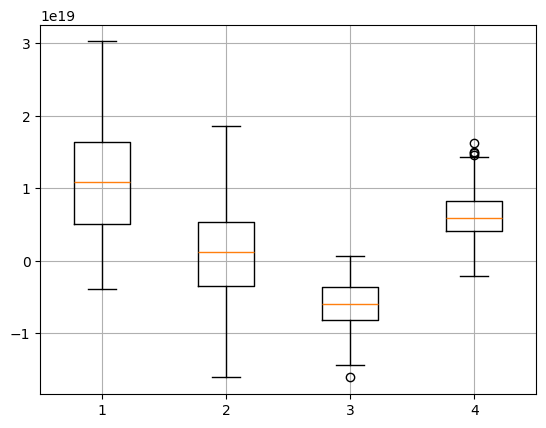

In [72]:
x=[]
for d in ['dsey','dsex','dsez','dsetot']:
#     print([np.cumsum(np.insert(e, 0, 0)) for e in dse_master[d]])
    x.append(([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]]))
#     print(d, np.mean([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]])/1e18, np.std([e.cumsum().mean().item() for e in dse_master[d]])/1e18)

plt.boxplot(x)
plt.grid()
# print(np.sum(x[:-1]))

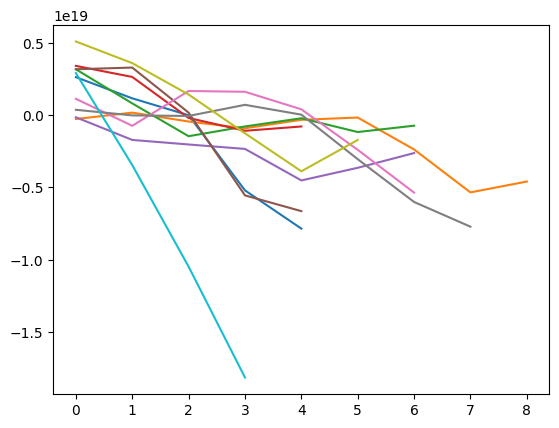

In [40]:
for e in dse_master['dsex'][10:20]:
    plt.plot(e)